# Project Name - Brain Tumor MRI Image Classification 

### Project Type - Image Classification 
### Name - Nilesh Bahirgaonkar

# Project Summary

- This project focuses on brain tumor MRI image classification using both Custom CNN (from Scratch) and Pre-trained models through transfer learning.
- The dataset is preprocessed with normalization, resizing them tp 224 x 224.
- Data Augmentation to improve generalization and performance. 
- Class imbalance has been dealed using computed class weights.
- A custom CNN is built, trained, evaluated and achieved and accuracy of 68%.
- Followed with a transfer learning using a pretrained model (MobileNetV2), which achieves better performance, it achieved an accuracy of 86%.
- Evaluation metrics like accuracy,precision,recall,F1 score has been calculated using classification report and confusion matrix is used.
- The final models have saved in .h5 format.

# GitHub Link 

# Problem Statement 

This project aims to develop a deep learning-based solution for classifying brain MRI images into multiple categories according to tumor type.

# Loading the data 

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = './'  


img_height, img_width = 224, 224
batch_size = 32

train_gen = ImageDataGenerator(rescale=1./255)
valid_gen = ImageDataGenerator(rescale=1./255)
test_gen  = ImageDataGenerator(rescale=1./255)


train_data = train_gen.flow_from_directory(
    directory=base_dir + 'train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_data = valid_gen.flow_from_directory(
    directory=base_dir + 'valid',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_gen.flow_from_directory(
    directory=base_dir + 'test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


# Understand the dataset

In [2]:
# Number of Categories 
print('Total Categories:',train_data.num_classes)

Total Categories: 4


In [3]:
# Check Categories names and their corressponding labels
print('Categories and their labels:',train_data.class_indices)

Categories and their labels: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}


In [4]:
# Total samples
print('Train Samples:',train_data.samples)
print('Test Samples:',test_data.samples)
print('Valid Samples:',valid_data.samples)

Train Samples: 1695
Test Samples: 246
Valid Samples: 502


In [5]:
# So we see that there are 4 Categories: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}, and are labelled as 0,1,2,3
# And we have 1695 Samples(images) in Train dataset
# 246 samples(images) in test dataset 
# 5502 samples(images) in valid dataset

### Checking for class imbalance and image distributions 

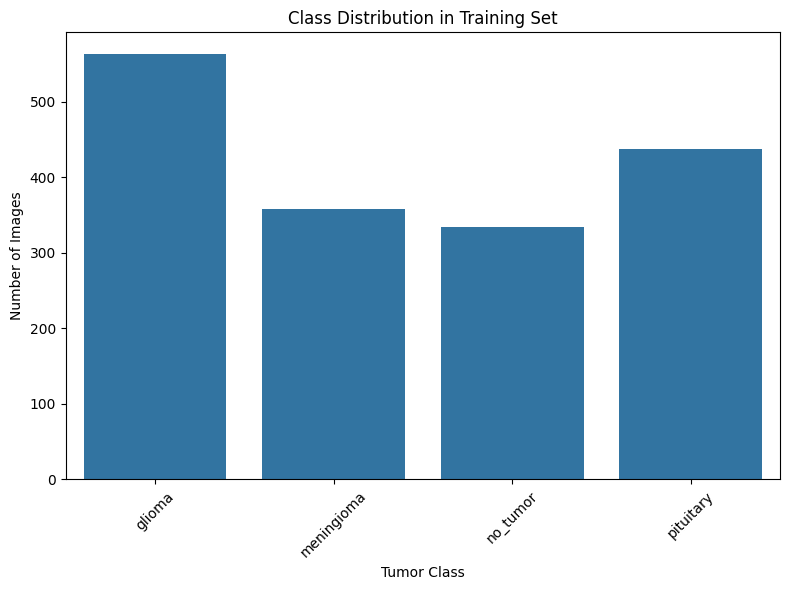

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get class labels and class names
class_labels = train_data.classes
class_names = list(train_data.class_indices.keys())

# Count images per class
class_counts = np.bincount(class_labels)

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_names, y=class_counts)
plt.title("Class Distribution in Training Set")
plt.xlabel("Tumor Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:
# So we see that our dataset is imbalanced.
# Glioma Samples are more than the other three categories. 
# we will be balancing the dataset using compute class weight

In [8]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np 

weights = compute_class_weight(class_weight='balanced',classes = np.unique(class_labels),y=class_labels)
class_weights = dict(enumerate(weights))

print("Class Weights:",class_weights)

Class Weights: {0: 0.7513297872340425, 1: 1.183659217877095, 2: 1.2649253731343284, 3: 0.9674657534246576}


In [9]:
# so the weights are balanced now

# Data Preprocessing  

### Normalizing the Pixel size

In [10]:
# In the Step 'loading dataset' we used imagegenerator, there we have normalized the pixel size to 0-1 using,

# train_gen = ImageDataGenerator(rescale=1./255)
# valid_gen = ImageDataGenerator(rescale=1./255)
# test_gen  = ImageDataGenerator(rescale=1./255)

### Resizing images to 224 x 224

In [11]:
# We have done this similar to normalizing, we have done it in loading dataset,

# we defined our pixel size:
    # img_height, img_width = 224, 224

# then we used them in generators :
# train_data = train_gen.flow_from_directory(
#     directory=base_dir + 'train',
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode='categorical'
# )

# valid_data = valid_gen.flow_from_directory(
#     directory=base_dir + 'valid',
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode='categorical'
# )

# test_data = test_gen.flow_from_directory(
#     directory=base_dir + 'test',
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode='categorical',
#     shuffle=False
# )

# now it will select all images and resize them to 224 x 224

# Data Augmentation 

In [12]:
# We will be applying data augmentation to only traininig data. 
# Will update the train_gen, we used it before only for normalizing(train_gen = ImageGenerator(rescale=1./255))

In [13]:
train_gen = ImageDataGenerator(rescale=1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rotation_range=20,
                               zoom_range=0.1,
                               brightness_range=(0.8,1.3),
                               horizontal_flip=True,
                               vertical_flip=False
)

In [14]:
# Loading the data again with updated train_gen

train_data = train_gen.flow_from_directory(
    directory=base_dir + 'train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1695 images belonging to 4 classes.


# Model Building 

### Custom CNN 

### Importing Libraries 

In [15]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential

### CNN 

In [16]:
model = Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape = (img_height,img_width,3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64,(3,3),activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128,(3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    Flatten(),
    Dense(128,activation='relu'),
    Dropout(0.5),
    Dense(train_data.num_classes,activation='softmax')
])

C:\Anaconda3\envs\py310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compiling the model 

In [17]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

### Summary

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,372 (42.61 MB)

 Trainable params: 11,169,924 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

### Training the Model

In [19]:
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=15,
                    class_weight=class_weights
)

C:\Anaconda3\envs\py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.4415 - loss: 8.8241 - val_accuracy: 0.2390 - val_loss: 16.9490
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.4118 - loss: 1.6122 - val_accuracy: 0.2351 - val_loss: 20.4384
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.4333 - loss: 1.2669 - val_accuracy: 0.2351 - val_loss: 19.5058
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.4159 - loss: 1.2871 - val_accuracy: 0.2390 - val_loss: 13.3611
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 722s 14s/step - accuracy: 0.3811 - loss: 1.3082 - val_accuracy: 0.2131 - val_loss: 2.5352
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.3240 - loss: 1.3535 - val_accuracy: 0.3147 - val_loss: 1.8790
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.3816 - loss: 1.2357 - val_accuracy: 0.3446 - val_loss: 1.5089
Epoch 8/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.4284 - loss: 1.2549 - val_accuracy: 0.5697 - val

# Transfer Learning 

### Import Libraries 

In [34]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [35]:
# Load base model 

base_model = MobileNetV2(input_shape=(224,224,3),
                         include_top=False,
                         weights='imagenet')

### Freezing the pretrained model 

In [36]:
base_model.trainable = False

In [37]:
# Since MobileNetV2 doesn’t know about brain tumors, we need to add our own dense layers to predict the 4 tumor types.

In [38]:
model_2 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128,activation='relu'),
    Dropout(0.3),
    Dense(train_data.num_classes,activation='softmax')
    
])

### Compiling the model 

In [39]:
model_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Training the model 

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping 
early_stop = EarlyStopping(monitor='val_loss',
                          patience=3,
                          restore_best_weights=True)

history_2 = model_2.fit(train_data,
                      validation_data=valid_data,
                      class_weight=class_weights,
                     epochs=20)

Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 47s 821ms/step - accuracy: 0.5908 - loss: 1.0717 - val_accuracy: 0.7729 - val_loss: 0.5609
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 791ms/step - accuracy: 0.8496 - loss: 0.4405 - val_accuracy: 0.8406 - val_loss: 0.4376
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 794ms/step - accuracy: 0.8925 - loss: 0.3219 - val_accuracy: 0.8705 - val_loss: 0.3701
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 44s 824ms/step - accuracy: 0.8993 - loss: 0.2944 - val_accuracy: 0.8825 - val_loss: 0.3405
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 784ms/step - accuracy: 0.8993 - loss: 0.2793 - val_accuracy: 0.8665 - val_loss: 0.3822
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 779ms/step - accuracy: 0.9034 - loss: 0.2705 - val_accuracy: 0.8606 - val_loss: 0.4080
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 781ms/step - accuracy: 0.9141 - loss: 0.2357 - val_accuracy: 0.8745 - val_loss: 0.3574
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 780ms/step - accuracy: 0.9183 - loss: 0.2284 - val_accu

# Model Evaluation

### For Custom CNN 

In [45]:
# Classification report 
from sklearn.metrics import classification_report
pred = model.predict(test_data)
pred_class = np.argmax(pred,axis=1)
test_class = test_data.classes
labels = list(test_data.class_indices.keys())
print(classification_report(pred_class,test_class,target_names=labels))

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step
              precision    recall  f1-score   support

      glioma       0.78      0.77      0.77        81
  meningioma       0.40      0.51      0.45        49
    no_tumor       0.63      0.79      0.70        39
   pituitary       0.93      0.65      0.76        77

    accuracy                           0.68       246
   macro avg       0.68      0.68      0.67       246
weighted avg       0.72      0.68      0.69       246



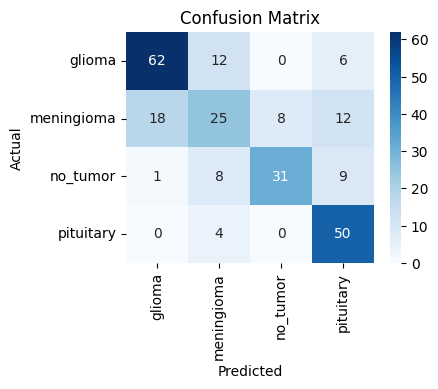

In [46]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
cm = confusion_matrix(test_class,pred_class)
plt.figure(figsize=[4,3])
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',
           xticklabels=labels,
           yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### For Pretrained Model 

In [49]:
# Classification report 
from sklearn.metrics import classification_report
pred_2 = model_2.predict(test_data)
pred_class_2 = np.argmax(pred_2,axis=1)
test_class_2 = test_data.classes
labels_2 = list(test_data.class_indices.keys())
print(classification_report(pred_class_2,test_class_2,target_names=labels_2))

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 420ms/step
              precision    recall  f1-score   support

      glioma       0.88      0.97      0.92        72
  meningioma       0.73      0.87      0.79        53
    no_tumor       0.86      0.95      0.90        44
   pituitary       1.00      0.70      0.82        77

    accuracy                           0.86       246
   macro avg       0.87      0.87      0.86       246
weighted avg       0.88      0.86      0.86       246



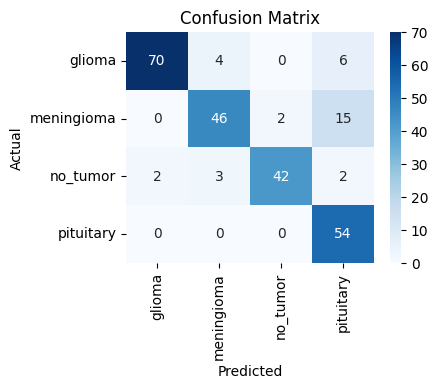

In [50]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_class_2,pred_class_2)
plt.figure(figsize=[4,3])
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',
           xticklabels=labels_2,
           yticklabels=labels_2)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualization  

### For Custom CNN
#### Visualizing Accuracy and Loss 

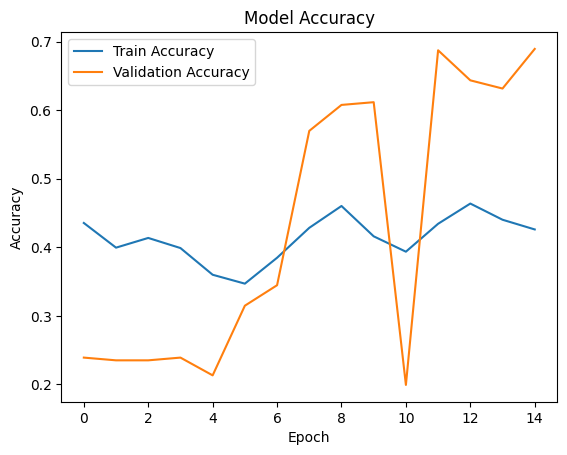

In [51]:
# Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Why did you choosed the specific chart ?

#### It is a line plot, above used for Visualizing the Model Accuracyof custom CNN.

#### What are the insights found from the chart?

#### - We see that Validation accuracy has a very noisy curve which indicates fluctations in validation accuracy.
#### - And also we see that, till 9th epoch the validation goes increasing, later faced fluctation.
#### - Train accuracy also has noisy curve, but smoother as compared to validation accuracy

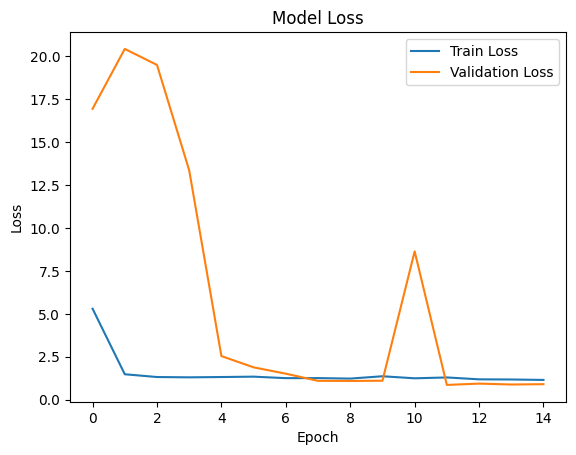

In [52]:
# Loss Plot 
plt.plot(history.history['loss'],label = 'Train Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Why did you choosed the specific chart ?

#### For Visualizing model Loss of Custom CNN.

#### What are the insights found from the chart?

#### - Validation loss has a large drop in between 2nd and 4th epoch.
#### - Train loss has a smoother curve as compared to validation loss.
#### - Both the curves nearly becomes asyptotes (i.e no change or minor change)

### For Pre-trained model

#### Visualizing Accuracy and Loss

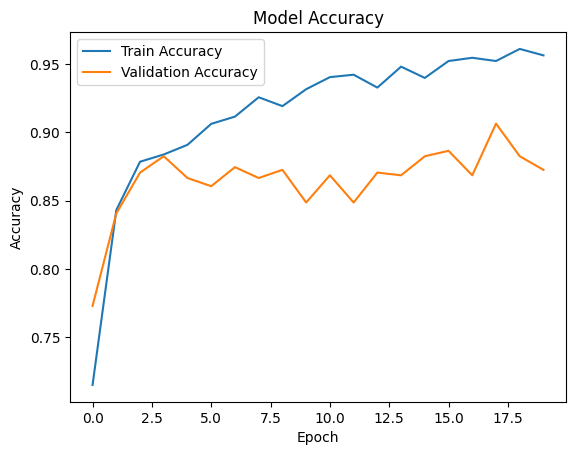

In [53]:
# Accuracy Plot
plt.plot(history_2.history['accuracy'],label = 'Train Accuracy')
plt.plot(history_2.history['val_accuracy'],label='Validation Accuracy')
plt.title('Pretrained Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Why did you choosed the specific chart ?

#### It is a line plot, above used for Visualizing the Model Accuracy of Pre-trained CNN.

#### What are the insights found from the chart?

#### - The Accuracies became better at every epoch.
#### - There are small fluctuations in both the curves, but has a small impact.
#### - Indicates good train and validation accuracy.

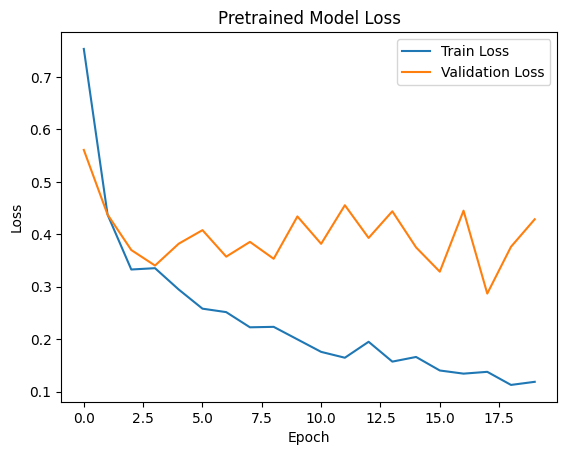

In [54]:
# Loss Plot
plt.plot(history_2.history['loss'],label = 'Train Loss')
plt.plot(history_2.history['val_loss'],label='Validation Loss')
plt.title('Pretrained Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Why did you choosed the specific chart ?

#### For Visualizing model Loss of Pretrained CNN.

#### What are the insights found from the chart?

#### - We see that the train loss has smoother curve as compared to validation loss.
#### - The validation loss is strucked in between 0.3 and 0.5, but not asymptote, there can be changes after some implementations.
#### - The train loss is decreasing and can be minimum if implemented in future.

# Model Comparison

### Custom CNN vs Transfer learning (Pretrained) Using **Metrics**

|Metrics|Custom CNN||Pretrained CNN|
|-|-|-|-|
|Accuracy|68%||86%|
|Precision|Low For Meningioma||Good For Every Class|
|Recall|Medium||Good For Every Class|
|F1 Score|Low for Meningioma||Strong|
|Summary|Simple Model, Fewer Layers||Used Pretrained model(MobileNetV2)|

### **Summary** - Custom CNN vs Pretrained CNN 

##### - The Custom Model achieved an accuracy of 68%, but struggled particularly with 'Meningioma' and 'Pituitary' classes.
##### - And as compared to Pretrained CNN, Custom CNN has a very low accuracy (68%). 
##### - The Pretrained model achieved an accuracy of 86%, which is considered good. 
##### - The Pretrained model also performed very well for both 'Meningioma' and 'Pituitary' classes where custom CNN failed.
##### - Also the training time for Pretrained model was less as compared to Custom CNN. 
##### - We see that overall performance of pretrained CNN is better as compared to Custom CNN.

### Best Model for Deployment 

##### Accuracy - Custom CNN vs Pretrained CNN (68 < 86).   
##### Overall performance - Pretrained CNN has better performance than Custom CNN.

#### The Pretrained CNN model is selected for deployment due to its higher accuracy, better class-wise performance. 

# Saving the model

In [62]:
model.save("custom_cnn_model.h5")
model_2.save("pretrained_model.h5")

# Conclusion

### - In conclusion, we successfully implemented and compared custom CNN and pre-trained CNN model for Brain Tumor classification using MRI images.
### - While the custom CNN achived moderate performance and the pre-trained CNN achieved strong performance as compared to custom CNN.
### - The pre-trained model has a very good accuracy of 86% and has strong values for all the classes of tumor.